In [1]:
import sys
sys.path.append('..')

from LiLY.modules.tv_golem import GolemModel
import torch
import torch.nn as nn
import torch.optim as optim
import os, pwd

import argparse
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ipdb
import pytorch_lightning as fpl
import wandb
from pytorch_lightning.loggers import WandbLogger
from einops import repeat
from LiLY.modules.CESM2 import CESM2ModularShiftsFixedB

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
from datetime import datetime
from tqdm import tqdm
from einops import repeat

from Caulimate.Data.SimLinGau import LinGauSuff
from Caulimate.Data.SimDAG import simulate_random_dag, simulate_weight, simulate_time_vary_weight
from Caulimate.Utils.Visualization import save_DAG, make_dots, plot_causal_graph, quick_map
from Caulimate.Utils.Tools import check_tensor, check_array, load_yaml, makedir, lin_reg_init, dict_to_class, save_log, bin_mat, center_and_norm, get_free_gpu
from Caulimate.Utils.GraphMetric import count_graph_accuracy
from Caulimate.Data.CESM2.dataset import CESM2_grouped_dataset, downscale_dataset
from Caulimate.Utils.GraphUtils import eudistance_mask, decycle_till_dag

DATA_DIR = '/l/users/minghao.fu/minghao.fu/dataset/CESM2' # you could modify it to your path
DOWNSCALE_PATH = os.path.join(DATA_DIR, 'downscaled_pacific_CESM2.txt')
DOWNSCALE_METADATA_PATH = os.path.join(DATA_DIR, 'downscaled_metadata.pkl')

SAVE_DIR = '/l/users/minghao.fu/minghao.fu/dataset/ClimateModel/LinGau/CESM2' # model and logs save dir
makedir(SAVE_DIR)
save_test_dir = './downscale_CESM2_eud_mask'

CKPT_PATH="./model.ckpt"

if torch.cuda.is_available():   
    os.environ["CUDA_VISIBLE_DEVICES"] = get_free_gpu()
    print(f"--- Selected GPU: {os.environ["CUDA_VISIBLE_DEVICES"]}")


args = {
    'data_path': "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_grouped_SST.nc",
    'noise_type': 'gaussian_ev',
    'load_data': True,
    'graph_type': 'ER',
    'num': 6000,
    'scale': 0.5,
    'pi': 10,
    'd_X': None,
    'degree': 4,
    'cos_len': 1000,
    'max_eud': 40,
    'equal_variances': True,

    'train': True,
    'pretrain': False,
    'checkpoint_path': None,
    'regression_init': False,
    'loss': {
        'likelihood': 1.0,
        'L1': 1.e-2,
        'dag': 1.e-2
    },
    'reg_thres': 0.05,
    'ddp': False,
    'pre_epoch': 0,
    'epoch': 10000,
    'init_epoch': 100,
    'batch_size': 64,
    'lag': 10,
    'synthetic': False,
    'time_varying': False,
    'sparse': False,

    'seed': 2,
    'gt_init': False,
    'embedding_dim': 5,
    'spectral_norm': False,
    'tol': 0.0,
    'graph_thres': 0.3,
    'DAG': 0.8,
    'save_dir': "/l/users/minghao.fu/logs/ClimateModel/LinGau/CESM2",

    'condition': "ignavier",
    'decay_type': "step",
    'optimizer': "ADAM",
    'weight_decay': 0.0,
    'lr': 1.e-4,
    'gradient_noise': None,
    'step_size': 1000,
    'gamma': 0.5,
    'decay': [200, 400, 800, 1000],
    'betas': [0.9, 0.999],
    'epsilon': 1.e-8,
    'momentum': 0.9
}

model = CESM2ModularShiftsFixedB.load_from_checkpoint(checkpoint_path=CKPT_PATH, strict=False)
model.eval()

/home/minghao.fu/.conda/envs/minghao_env/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/minghao.fu/workspace/climate/SSM/../LiLY/modules/components/beta.py:364: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


CESM2ModularShiftsFixedB(
  (dyn_embed_func): Embedding(12, 2)
  (obs_embed_func): Embedding(12, 2)
  (pos_embed_func): PartiallyPeriodicMLP(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (fc3): Linear(in_features=8, out_features=4, bias=True)
    (sigmoid): Sigmoid()
    (relu): ReLU()
    (leakyrelu): LeakyReLU(negative_slope=0.2)
  )
  (decode_coord): Sequential(
    (0): LeakyReLU(negative_slope=0.2)
    (1): Linear(in_features=6, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=128, out_features=3, bias=True)
  )
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=82, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slo

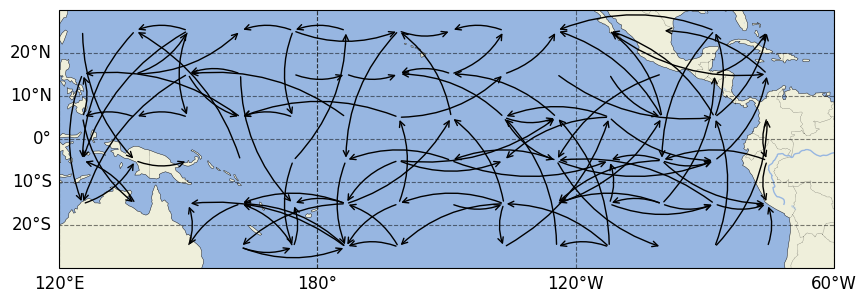

In [2]:
dataset = downscale_dataset(path=DOWNSCALE_PATH, metadata_path=DOWNSCALE_METADATA_PATH)#CESM2_grouped_dataset(args.data_path, num_area=1)[0]
Bs = check_array(model.generate_Bs(check_tensor(dataset.T).squeeze(1)))

import cartopy.crs as ccrs
import cartopy
import numpy as np
import matplotlib.pyplot as plt 

# mask = np.load(os.path.join(save_test_dir, 'mask.npy'))
Bt = Bs[1000]
coords = np.load(os.path.join(save_test_dir, 'coords.npy'))

Bt[np.abs(Bt) < 0.755] = 0 
Bt = decycle_till_dag(Bt)  
center=180
# Assuming coords is a list of tuples, where each tuple is (lat, lon)
adjusted_coords = [(lat, 180 - lon if lon <= 180 else lon - 180) for lat, lon in coords]

fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center)})
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable labels at the top
gl.right_labels = False  # Disable labels on the right
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

def offset_path(start, end, offset):
    start_lon, start_lat = start
    end_lon, end_lat = end
    mid_lon = (start_lon + end_lon) / 2 + offset
    mid_lat = (start_lat + end_lat) / 2 + offset
    return [(start_lon, start_lat), (mid_lon, mid_lat), (end_lon, end_lat)]

# 根据邻接矩阵绘制因果连接
offset = 0.5  # 偏移量

for i in range(len(Bt)):
    for j in range(len(Bt)):
        if Bt[i, j] != 0:
            point1 = coords[i]
            point2 = coords[j]
            # 处理跨越日期变更线的情况
            # if abs(point1[1] - point2[1]) > 180:
            #     if point1[1] > point2[1]:
            #         point2 = (point2[0], point2[1] + 360)
            #     else:
            #         point1 = (point1[0], point1[1] + 360)
            path = offset_path(point1, point2, offset * (i + j))
            xs, ys = zip(*path)
            ax.plot(xs, ys, color='red', linewidth=1, transform=ccrs.PlateCarree())
            ax.annotate('', xy=(point2[1], point2[0]), xytext=(point1[1], point1[0]),
                        arrowprops=dict(facecolor='red', arrowstyle='->', lw=1, connectionstyle="arc3,rad=.2"), #arc3,rad=.2
                        transform=ccrs.PlateCarree())
            

for lat, lon in coords:
    ax.annotate('', xy=(lon - 180, lat), xytext=(lon - 180, lat),
                            arrowprops=dict(facecolor='red', arrowstyle='->', lw=1))
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
#plt.savefig(os.path.join(save_test_dir, 'LinRegInit.pdf'), format='pdf', bbox_inches='tight')

In [3]:
zs = model.

SyntaxError: invalid syntax (736863307.py, line 1)